In [2]:
# import first or else jupyter crashes 

from desc.plotting import plot_section
from desc.plotting import (
    plot_grid,
    plot_boozer_modes,
    plot_boozer_surface,
    plot_qs_error,
    plot_boundaries,
    plot_boundary,
)
import desc
import matplotlib.pyplot as plt
from desc.basis import ChebyshevFourierSeries


from desc.transform import Transform
from desc.equilibrium import Equilibrium
from desc.basis import ChebyshevZernikeBasis, chebyshev_z
from desc.compute import compute
from desc.grid import LinearGrid, ConcentricGrid, QuadratureGrid, Grid
from desc.compute.utils import get_transforms
from desc.objectives import (
    FixEndCapLambda,
    FixEndCapR,
    FixEndCapZ,
    FixBoundaryR,
    FixBoundaryZ,
    FixPsi,
    FixPressure,
    FixIota,
    ForceBalance,
    ObjectiveFunction,
    CurrentDensity,
    MatchEndCapR,
    MatchEndCapZ,
    MatchEndCapLambda,
    ForceBalanceAnisotropic,
    MagneticWell,
    FixAnisotropy,
)
import numpy as np
from desc.optimize import Optimizer
from desc.profiles import PowerSeriesProfile
from desc.geometry import FourierRZToroidalSurface
from scipy.constants import mu_0
from mayavi import mlab

def chebygrid(N_grid):
    return np.concatenate(
        (
            [0],
            (-np.cos((2 * np.arange(N_grid) + 1) * np.pi / (2 * N_grid)) + 1) * np.pi,
            [2 * np.pi],
        )
    )


def grid_gen(L_grid, M_grid, N_grid, node_pattern="jacobi"):
    LMnodes = ConcentricGrid(L=L_grid, M=M_grid, N=0, node_pattern=node_pattern).nodes[
        :, :2
    ]
    Nnodes = chebygrid(N_grid)
    lm = np.tile(LMnodes, (Nnodes.size, 1))
    n = np.tile(Nnodes.reshape(-1, 1), (1, LMnodes.shape[0])).reshape(-1, 1)
    nodes = np.concatenate((lm, n), axis=1)

    # RG: weights and spacing defined here
    # just for the sake of compilation. Must be checked
    weights = np.ones(nodes.shape[0])
    spacing = np.ones_like(nodes)

    spacing[1:, 1] = np.diff(nodes[:, 1])
    spacing[1:, 2] = np.diff(nodes[:, 2])

    return Grid(nodes, spacing = spacing, weights = weights)

    
def get_lm_mode(basis, coeff, zeta, L, M, func_zeta=chebyshev_z):
    modes = basis.modes
    lm = 0
    for i, (l, m, n) in enumerate(modes):
        if l == L and m == M:
            lm += func_zeta(zeta, n)*coeff[i]
    return lm



plt.rcParams.update({
    "font.size": 16,           # Default text size
    "axes.titlesize": 18,      # Title font
    "axes.labelsize": 16,      # x/y label font
    "xtick.labelsize": 14,     # Tick font
    "ytick.labelsize": 14,
    "legend.fontsize": 14,
})


## test 
surf = FourierRZToroidalSurface(
    R_lmn=[10,1,-0.5,0.5],
    modes_R=[[0,0],[1,0],[1,2],[1,4]],
    Z_lmn=[0,-1, 0.5,-0.5],
    modes_Z=[[0,0],[-1,0], [-1,2],[-1,4]],
    NFP=1,
    sym=False,
    mirror=True
)

## test 
surf = FourierRZToroidalSurface(
    R_lmn=[10,1,-0.5],
    modes_R=[[0,0],[1,0],[1,2]],
    Z_lmn=[0,-1, 0.5],
    modes_Z=[[0,0],[-1,0], [-1,2]],
    NFP=1,
    sym=False,
    mirror=True
)




p = PowerSeriesProfile(params=[0.001 / mu_0, -0.001 / mu_0], modes=[0, 2])
iota = PowerSeriesProfile(params=[0.0, 0])


eq = Equilibrium(
    surface=surf,
    L=5,
    M=2,
    N=8,
    mirror=True,
    pressure=p,
    iota=iota,
    sym=False,
)



In [4]:
p.set_params(0,a=0e6) #= array([-1000])
p.set_params(2,a=-0e6) #= array([-1000])

In [6]:
surf_init = surf.copy()

In [7]:
eq = Equilibrium(
    surface=surf_init,
    L=5,
    M=2,
    N=8,
    mirror=True,
    pressure=p,
    iota=iota,
    sym=False,
)

In [8]:
eq_start = eq.copy()

Text(0.5, 1.0, 'MR = 8.996976822325658')

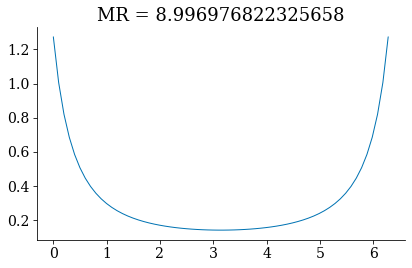

In [9]:
# ---- Grid for axis (rho = 0, theta = 0, zeta from 0 to 2pi) ----
zeta_axis = np.linspace(0, 2*np.pi, 64)
rho_axis = np.zeros_like(zeta_axis)
theta_axis = np.zeros_like(zeta_axis)
grid_axis = Grid(np.stack([rho_axis, theta_axis, zeta_axis], axis=1))

# Compute on axis
data_axis = eq.compute(['|B|', 'p','beta_a','Y'], grid=grid_axis)
B_axis = data_axis['|B|']
p_perp_axis = data_axis["p"]

plt.figure()
plt.plot(zeta_axis,B_axis)
plt.title('MR = {}'.format(np.max(B_axis)/np.min(B_axis)))


In [10]:
### Lower B magnitude by 10x

eq.Psi = 1/np.max(B_axis)

In [11]:
eq.Psi

0.7853981633974483

In [12]:
#eq.change_resolution(L = 10, M = 4, N = 8)

In [13]:
constraints = (
     #FixEndCapLambda(0, eq=eq),
     #FixEndCapR(0, eq=eq),
     #FixEndCapZ(0, eq=eq),
     #FixEndCapLambda(2*np.pi, eq=eq),
     #FixEndCapR(2*np.pi, eq=eq),
     #FixEndCapZ(2*np.pi, eq=eq),
     MatchEndCapR(eq=eq),
     MatchEndCapZ(eq=eq),
     MatchEndCapLambda(eq=eq),
    #EndCapMatchLambda_Rot(eq=eq),
    #EndCapMatchR_Rot(eq=eq),
    #EndCapMatchZ_Rot(eq=eq),
    FixBoundaryR(eq=eq),
    FixBoundaryZ(eq=eq),
    FixPressure(eq=eq),
    FixIota(eq=eq),
    FixPsi(eq=eq),
    #FixAnisotropy(eq=eq),
)
optimizer = Optimizer("lsq-exact")
grid = grid_gen(10, 20, 20)
# objectives = CurrentDensity(eq=eq, grid=grid)
#objectives = ForceBalance(eq=eq, grid=grid)
#objectives = [ForceBalance(eq=eq, grid=grid), 100.0 * symmetry_obj]
#obj = ObjectiveFunction(objectives=objectives)
#force_obj = ForceBalanceAnisotropic(eq=eq, grid=grid)
#obj = ObjectiveFunction(objectives=[force_obj])

aFB = ForceBalance(eq=eq, grid=grid)

stab = MagneticWell(eq = eq)
obj = ObjectiveFunction(objectives=[aFB])

eq.solve(
    objective=obj,
    constraints=constraints,
    optimizer=optimizer,
    ftol=1e-8,
    xtol=1e-16,
    gtol=1e-16,
    maxiter = 20,
    verbose=2,

)

Building objective: force
Precomputing transforms
Timer: Precomputing transforms = 610 ms
Timer: Objective build = 1.06 sec
Building objective: MatchR at Endcaps
Building objective: matchZ at Endcaps
Building objective: MatchL at Endcaps
Building objective: lcfs R
Building objective: lcfs Z
Building objective: fixed pressure
Building objective: fixed iota
Building objective: fixed Psi
Building objective: self_consistency R
Building objective: self_consistency Z
Building objective: lambda gauge
Building objective: axis R self consistency
Building objective: axis Z self consistency
Timer: Objective build = 495 ms
Timer: LinearConstraintProjection build = 2.64 sec
Number of parameters: 208
Number of objectives: 6072
Timer: Initializing the optimization = 4.22 sec

Starting optimization
Using method: lsq-exact
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1          2.362e+01                                    5.194e+00   


(Equilibrium at 0x32252d310 (L=5, M=2, N=8, NFP=1, sym=False, spectral_indexing=ansi),
           message: Maximum number of iterations has been exceeded.
           success: False
               fun: [ 5.414e-06 -3.074e-06 ...  2.552e-05  1.098e-05]
                 x: [-1.650e+00 -4.101e-01 ...  1.877e-01 -4.312e-01]
               nit: 20
              cost: 1.7683921493218724e-06
                 v: [ 1.000e+00  1.000e+00 ...  1.000e+00  1.000e+00]
        optimality: 9.802858857710139e-06
              nfev: 30
              njev: 21
              allx: [Array([ 1.000e+01, -7.544e-16, ...,  0.000e+00,
                            0.000e+00], dtype=float64), Array([ 9.999e+00, -2.349e-04, ...,  0.000e+00,
                            0.000e+00], dtype=float64), Array([ 1.000e+01, -4.598e-04, ...,  0.000e+00,
                            0.000e+00], dtype=float64), Array([ 9.999e+00, -2.750e-04, ...,  0.000e+00,
                            0.000e+00], dtype=float64), Array([ 9.993e+00,

In [24]:
f = (
    eq.compute("<|F|>_vol")["<|F|>_vol"]
    / eq.compute("<|grad(|B|^2)|/2mu0>_vol")["<|grad(|B|^2)|/2mu0>_vol"]
)

print(f"Force error after eq.solve(): {f:.4e}")


Force error after eq.solve(): 9.9233e-05


In [26]:
eq.compute("|F|", grid = grid)["|F|"].max()

Array(5.40166756, dtype=float64)

In [28]:
grid = grid_gen(10, 20, 20)


Precomputing transforms


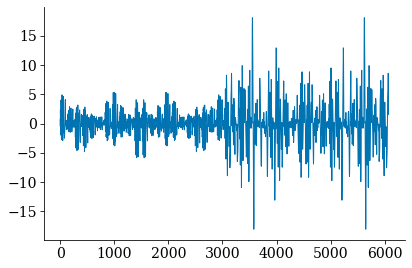

In [30]:
fb = ForceBalance(eq = eq, grid=grid)
fb.build()
fb_test = fb.compute(eq.params_dict)
plt.plot(fb_test)


In [32]:
fb_test.shape

(6072,)

In [34]:
data = eq.compute(['X','Y','Z'], grid = grid)

In [36]:
fb_radial = fb_test[:len(data['X'])]

In [38]:
fb_helical = fb_test[len(data['X']):]

In [40]:
fb_radial.shape,fb_helical.shape

((3036,), (3036,))

In [42]:
#3D
x = data['X']
y = data['Y']
z = data['Z']


fig = mlab.figure(bgcolor = (1,1,1),fgcolor=(0.,0.,0.))
points = mlab.points3d(x,y,z,fb_radial,scale_factor = .1, scale_mode = 'none')


mlab.show()

In [91]:
#3D
x = data['X']
y = data['Y']
z = data['Z']


fig = mlab.figure(bgcolor = (1,1,1),fgcolor=(0.,0.,0.))
points = mlab.points3d(x,y,z,fb_helical,scale_factor = .1, scale_mode = 'none')


mlab.show()

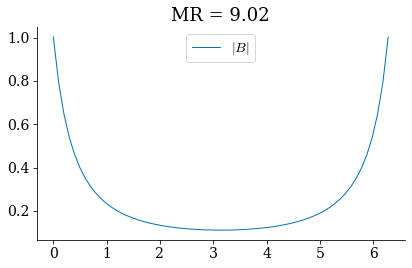

In [44]:
# ---- Grid for axis (rho = 0, theta = 0, zeta from 0 to 2pi) ----
zeta_axis = np.linspace(0, 2*np.pi, 64)
rho_axis = np.ones_like(zeta_axis)*0
theta_axis = np.zeros_like(zeta_axis)
grid_axis = Grid(np.stack([rho_axis, theta_axis, zeta_axis], axis=1))

# Compute on axis
data_axis = eq.compute(['|B|', 'p','Y'], grid=grid_axis)
B_axis = data_axis['|B|']
p_perp_axis = data_axis["p"]

plt.figure()
plt.plot(zeta_axis,B_axis,label = r"$|B|$")
plt.title('MR = {:.2f}'.format(np.max(B_axis)/np.min(B_axis)))
plt.legend()

In [46]:
# %% Get fieldlines on the LCFS
#assert isinstance(eq, Equilibrium)

Nz = 200
Nt = 100
rho_surf = .5

theta = np.linspace(0, 2 * np.pi, Nt)
zeta = np.linspace(0, 2 * np.pi, Nz, endpoint=True)

theta_mesh, zeta_mesh = np.meshgrid(theta, zeta, indexing="ij")
shape = theta_mesh.shape
coords_sfl = np.stack(
    [
        np.ones_like(theta_mesh.reshape(-1))*rho_surf,
        theta_mesh.reshape(-1),
        zeta_mesh.reshape(-1),
    ],
    axis=-1,
)

coords_geo = eq.compute_theta_coords(coords_sfl)
coords_data = eq.compute(["R", "Z", "zeta","p","|B|",'kappa'], grid=Grid(nodes=coords_geo, sort=False))


lines = np.array([coords_data["R"], coords_data["zeta"], coords_data["Z"]])
lines = lines.reshape(3, shape[0], shape[1])
lines = np.moveaxis(lines, [0, 1], [1, 0])

B_on_lines = coords_data["|B|"]
B_on_lines = B_on_lines.reshape(shape[0], shape[1])


p_on_lines = coords_data["p"]
p_on_lines = p_on_lines.reshape(shape[0], shape[1])
k_on_lines = coords_data["kappa"]
k_on_lines = np.linalg.norm(k_on_lines,axis = -1)
k_on_lines = k_on_lines.reshape(shape[0], shape[1])

In [48]:
data_mesh = eq.compute(['theta','X','Y','Z','|B|','B','p','J','e^theta','e^rho','e^zeta','grad(alpha)'],grid=Grid(nodes=coords_geo, sort=False))

### axial pressure profile 
mu0 = 4 * np.pi * 1e-7

# ---- Grid for axis (rho = 0, theta = 0, zeta from 0 to 2pi) ----
zeta_axis = np.linspace(0, 2*np.pi, 100)
rho_axis = np.zeros_like(zeta_axis)
theta_axis = np.zeros_like(zeta_axis)
grid_axis = Grid(np.stack([rho_axis, theta_axis, zeta_axis], axis=1))

# Compute on axis
data_axis = eq.compute(["|B|", "p"], grid=grid_axis)
B_axis = data_axis["|B|"]
p_axis = data_axis["p"]


# ---- Grid for midplane slice (zeta = pi, theta = 0, rho from 0 to 1) ----
rho_mid = np.linspace(0, 1, 100)
theta_mid = np.zeros_like(rho_mid)
zeta_mid = np.ones_like(rho_mid) * np.pi
grid_mid = Grid(np.stack([rho_mid, theta_mid, zeta_mid], axis=1))

# Compute on midplane profile
data_mid = eq.compute(["p",'|B|',"p"], grid=grid_mid)
B_mid = data_mid["|B|"]
p_mid = data_mid["p"]


X2d = np.reshape(data_mesh['X'],(Nz,Nt))
Y2d = np.reshape(data_mesh['Y'],(Nz,Nt))
Z2d = np.reshape(data_mesh['Z'],(Nz,Nt))
B2d = np.reshape(data_mesh['|B|'],(Nz,Nt))
J2d = np.reshape(data_mesh['J'],(Nz,Nt,3))
theta2d = np.reshape(data_mesh['theta'],(Nz,Nt))

etheta = np.reshape(data_mesh['e^theta'],(Nz,Nt,3)) 
ezeta = np.reshape(data_mesh['e^zeta'],(Nz,Nt,3))
erho = np.reshape(data_mesh['e^rho'],(Nz,Nt,3))

e_theta_n = etheta / np.linalg.norm(etheta,axis = -1)[:,:,None]
e_zeta_n = ezeta / np.linalg.norm(ezeta,axis = -1)[:,:,None]
e_rho_n = erho / np.linalg.norm(erho,axis = -1)[:,:,None]

J2d_n = J2d / np.linalg.norm(J2d,axis = -1)[:,:,None]

comp_theta = np.sum(J2d_n*e_theta_n,axis = -1)
comp_zeta = np.sum(J2d_n*e_zeta_n,axis = -1)
comp_rho = np.sum(J2d_n*e_rho_n,axis = -1)

Bv = np.reshape(data_mesh['B'],(Nz,Nt,3))
B2d_n = Bv / np.linalg.norm(Bv,axis = -1)[:,:,None]

JdotB = np.sum(J2d_n*B2d_n,axis = -1)

#gradp = np.reshape(data_mesh['grad(p)'],(Nz,Nt,3))
#gradp_n =  gradp / np.linalg.norm(gradp,axis = -1)[:,:,None]

#Jdotgradp = np.sum(J2d_n*gradp_n,axis = -1)

#Bdotgradp = np.sum(B2d_n*gradp_n,axis = -1)

JdotB2d_n = np.sum(J2d_n*B2d_n,axis = -1)

gradalpha = np.reshape(data_mesh['grad(alpha)'],(Nz,Nt,3))
gradalpha_n = gradalpha / np.linalg.norm(gradalpha,axis = -1)[:,:,None]

Jdotgradalpha_n =  np.sum(J2d_n*gradalpha_n,axis = -1)

beta = 2*(data_mesh['p'])*mu_0 / (data_mesh["|B|"]**2  + 1e-20)  
beta_axis = 2*(data_axis['p'])*mu_0 / (data_axis["|B|"]**2  + 1e-20)
beta_midplane = 2*(data_mid['p'])*mu_0 / (data_mid["|B|"]**2  + 1e-20)


beta2d = np.reshape(beta,(Nz,Nt))

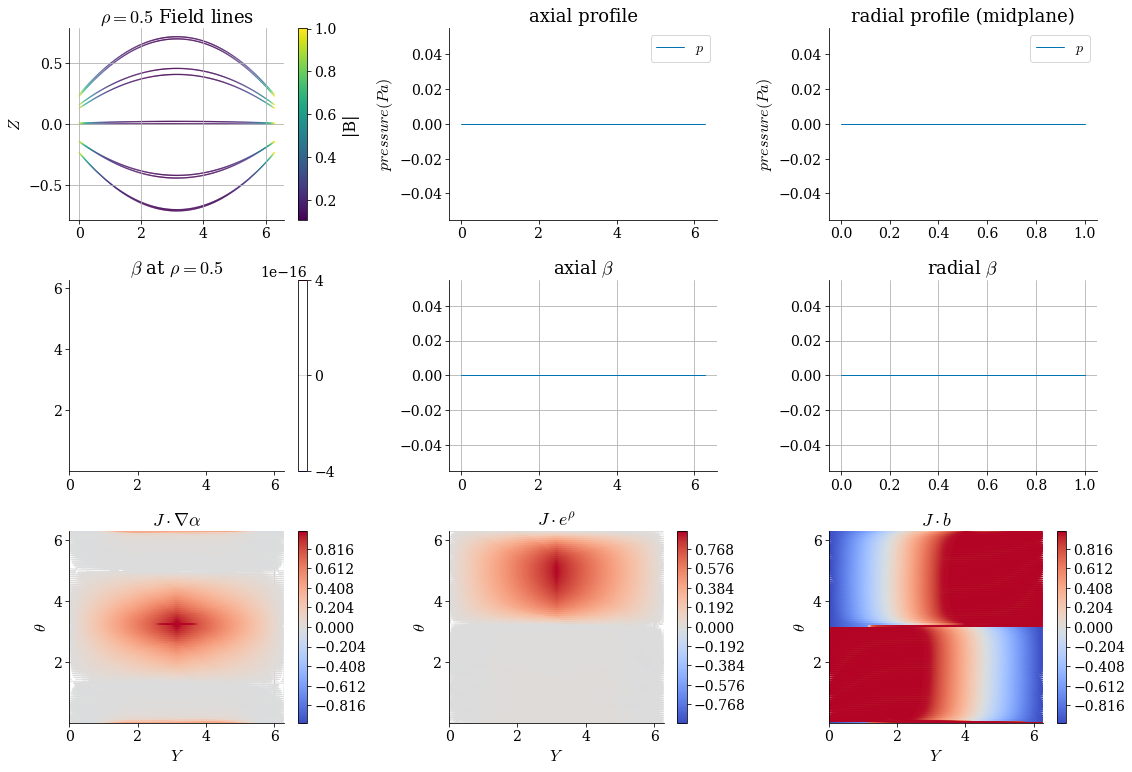

In [49]:
fig, axs = plt.subplots(3,3,figsize=(16, 11))

nlevels = 500
cmap='coolwarm'

# field lines 
i = 0
for line in lines[::10]:
    fieldlines = axs[0,0].scatter(line[1],line[2],c= B_on_lines[i], s = .2)
    i = i + 10
fig.colorbar(fieldlines, ax=axs[0,0],label = r'|B|')

#

axs[0,1].plot(zeta_axis,p_axis, label = r'$p$')
axs[0,1].legend()

axs[0,2].plot(rho_mid,p_mid, label = r'$p$')
axs[0,2].legend()




im = axs[1,0].contour(Y2d,theta2d,beta2d,levels = nlevels,cmap=cmap)
fig.colorbar(im, ax=axs[1,0])


im = axs[1,1].plot(zeta_axis,beta_axis)
im = axs[1,2].plot(rho_mid,beta_midplane)





# J
im = axs[2,1].contour(Y2d,theta2d,comp_rho,levels = nlevels,cmap=cmap)
fig.colorbar(im, ax=axs[2,1])

im = axs[2,0].contour(Y2d,theta2d,Jdotgradalpha_n,levels = nlevels,cmap=cmap)
fig.colorbar(im, ax=axs[2,0])

im = axs[2,2].contour(Y2d,theta2d,JdotB2d_n,levels = nlevels,cmap=cmap)
fig.colorbar(im, ax=axs[2,2])



# titles
axs[0,0].set_title(r'$\rho = {}$ Field lines'.format(rho_surf))
axs[0,1].set_title('axial profile')
axs[0,2].set_title('radial profile (midplane)')

axs[1,0].set_title(r'$\beta$ at $\rho = {}$ '.format(rho_surf))
axs[1,1].set_title(r'axial $\beta$')
axs[1,2].set_title(r'radial $\beta$')

axs[2,2].set_title(r'$J \cdot b$')
axs[2,0].set_title(r'$J \cdot \nabla \alpha$')
axs[2,1].set_title(r'$J \cdot e^\rho$')

axs[0,0].set_ylabel(r'$Z$')
axs[0,1].set_ylabel(r'$pressure(Pa)$')
axs[0,2].set_ylabel(r'$pressure(Pa)$')

axs[2,2].set_ylabel(r'$\theta$')
axs[2,0].set_ylabel(r'$\theta$')
axs[2,1].set_ylabel(r'$\theta$')


axs[2,0].set_xlabel(r'$Y$')
axs[2,1].set_xlabel(r'$Y$')
axs[2,2].set_xlabel(r'$Y$')


axs[0,0].grid()
axs[1,1].grid()
axs[1,2].grid()

axs[2,2].grid()
axs[2,0].grid()
axs[2,1].grid()

fig.tight_layout()

(<Figure size 864.648x576.432 with 1 Axes>,
 <Axes: xlabel='$\\rho$', ylabel='$ \\mathrm{Magnetic ~Well}~(~)$'>)

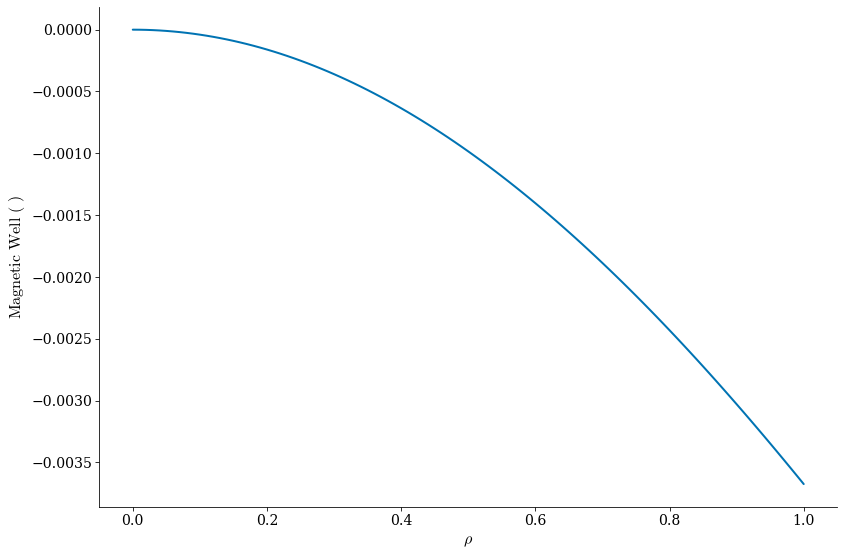

In [53]:
# Create a figure and axis manually
fig, ax = plt.subplots(figsize=(12, 8))

# Plot on the custom axis
desc.plotting.plot_1d(
    eq,
    name="magnetic well",
    ax=ax,         
    lw=2
)

In [59]:
# %% Get fieldlines on the LCFS
#assert isinstance(eq, Equilibrium)

Nz = 50
Nt = 50
Nr = 3

theta = np.linspace(0, 2 * np.pi, Nt)
zeta = np.linspace(0, 2 * np.pi, Nz, endpoint=False)
rho = np.linspace(0,1,Nr)

full_coords = []
for r in rho:

    theta_mesh, zeta_mesh = np.meshgrid(theta, zeta, indexing="ij")
    shape = theta_mesh.shape
    coords_sfl = np.stack(
        [
            np.ones_like(theta_mesh.reshape(-1))*r,
            theta_mesh.reshape(-1),
            zeta_mesh.reshape(-1),
        ],
        axis=-1,
    )

    coords_geo = eq.compute_theta_coords(coords_sfl)
    
    full_coords.append(coords_geo)
    
full_coords = np.array(full_coords)

In [61]:
# RG: weights and spacing defined here
# just for the sake of compilation. Must be checked
weights = np.ones(coords_sfl.shape[0])
spacing = np.ones_like(coords_sfl)

spacing[1:, 1] = np.diff(coords_sfl[:, 1])
spacing[1:, 2] = np.diff(coords_sfl[:, 2])

In [63]:
#grid=Grid(nodes=coords_geo,weights = weights, spacing = spacing, sort=False)


In [65]:
coords_geo = np.array([full_coords[:,:,0].ravel(),full_coords[:,:,1].ravel(),full_coords[:,:,2].ravel()]).T
grid=Grid(nodes=coords_geo, sort=False)
#data = eq.compute(['isodynamicity','X','Y','Z','|B|','<beta>_vol','beta_a','|F|','p','grad(p)','J','|J|','J_rho','J_theta','J_zeta','J*B','J_parallel'], grid = grid)
data = eq.compute(['X','Y','Z','|B|','|F|','p','grad(p)','J','|J|','J_rho','J_theta','J_zeta','J*B','J_parallel','kappa'], grid = grid)

In [69]:
grid = LinearGrid(
    M=eq.M_grid,
    N=eq.N_grid,
    NFP=eq.NFP,
    rho=np.linspace(0.5, 1, 3),
    sym=False,
)

In [71]:
data = eq.compute(['X','Y','Z','|B|','|F|','p','grad(p)','J','|J|','J_rho','J_theta','J_zeta','J*B','J_parallel','kappa'], grid = grid)

In [72]:
#3D

x = data['X']
y = data['Y']
z = data['Z']
#b = data['p']
#bv = data['grad(p)']
bv = data['B']

fig = mlab.figure(bgcolor = (1,1,1),fgcolor=(0.,0.,0.))

points = mlab.points3d(x,y,z,scale_factor = .01, scale_mode = 'none')
arrows = mlab.quiver3d(x,y,z,bv[:,0],bv[:,1],bv[:,2], scale_factor=.1, line_width=10,scale_mode = 'none')

#bv = data['kappa']
#arrows1 = mlab.quiver3d(x,y,z,bv[:,0],bv[:,1],bv[:,2], scale_factor=.1, line_width=10,scale_mode = 'none', color = (1,0,1))

#bv = data['e^zeta']
#arrows2 = mlab.quiver3d(x,y,z,bv[:,0],bv[:,1],bv[:,2], scale_factor=.1, line_width=10,scale_mode = 'none',color = (1,0,0))

#bv = data['e^theta']
#arrows3 = mlab.quiver3d(x,y,z,bv[:,0],bv[:,1],bv[:,2], scale_factor=.1, line_width=10,scale_mode = 'none',color = (0,0,1))


#mlab.colorbar(arrows)


mlab.show()

In [75]:
### Add pressure
eq_no_p = eq.copy()

In [79]:
eq = eq_no_p.copy()

In [81]:
eq.pressure.set_params(0,a=2e3)
eq.pressure.set_params(2,a=-2e3)

Text(0.5, 1.0, 'MR = 9.019726432609328')

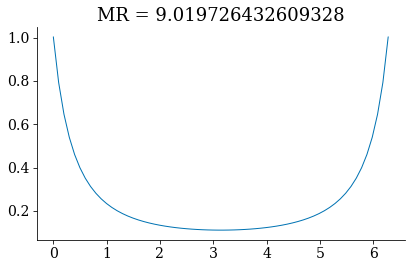

In [83]:
# ---- Grid for axis (rho = 0, theta = 0, zeta from 0 to 2pi) ----
zeta_axis = np.linspace(0, 2*np.pi, 64)
rho_axis = np.zeros_like(zeta_axis)
theta_axis = np.zeros_like(zeta_axis)
grid_axis = Grid(np.stack([rho_axis, theta_axis, zeta_axis], axis=1))

# Compute on axis
data_axis = eq.compute(['|B|', 'p','beta_a','Y'], grid=grid_axis)
B_axis = data_axis['|B|']
p_perp_axis = data_axis["p"]

plt.figure()
plt.plot(zeta_axis,B_axis)
plt.title('MR = {}'.format(np.max(B_axis)/np.min(B_axis)))

In [84]:
constraints = (
     #FixEndCapLambda(0, eq=eq),
     #FixEndCapR(0, eq=eq),
     #FixEndCapZ(0, eq=eq),
     #FixEndCapLambda(2*np.pi, eq=eq),
     #FixEndCapR(2*np.pi, eq=eq),
     #FixEndCapZ(2*np.pi, eq=eq),
     MatchEndCapR(eq=eq),
     MatchEndCapZ(eq=eq),
     MatchEndCapLambda(eq=eq),
    #EndCapMatchLambda_Rot(eq=eq),
    #EndCapMatchR_Rot(eq=eq),
    #EndCapMatchZ_Rot(eq=eq),
    FixBoundaryR(eq=eq),
    FixBoundaryZ(eq=eq),
    FixPressure(eq=eq),
    FixIota(eq=eq),
    FixPsi(eq=eq),
    #FixAnisotropy(eq=eq),
)
optimizer = Optimizer("lsq-exact")
grid = grid_gen(20, 20, 20)
# objectives = CurrentDensity(eq=eq, grid=grid)
#objectives = ForceBalance(eq=eq, grid=grid)
#objectives = [ForceBalance(eq=eq, grid=grid), 100.0 * symmetry_obj]
#obj = ObjectiveFunction(objectives=objectives)
#force_obj = ForceBalanceAnisotropic(eq=eq, grid=grid)
#obj = ObjectiveFunction(objectives=[force_obj])

aFB = ForceBalance(eq=eq, grid=grid, weight = 1e8)

stab = MagneticWell(eq = eq,weight = 1e8)
obj = ObjectiveFunction(objectives=[aFB,stab])

eq.solve(
    objective=obj,
    constraints=constraints,
    optimizer=optimizer,
    ftol=1e-8,
    xtol=1e-16,
    gtol=1e-16,
    maxiter = 50,
    verbose=2,

)

Building objective: force
Precomputing transforms
Timer: Precomputing transforms = 667 ms
Building objective: Magnetic Well
Precomputing transforms
Timer: Precomputing transforms = 489 ms
Timer: Objective build = 1.34 sec
Building objective: MatchR at Endcaps
Building objective: matchZ at Endcaps
Building objective: MatchL at Endcaps
Building objective: lcfs R
Building objective: lcfs Z
Building objective: fixed pressure
Building objective: fixed iota
Building objective: fixed Psi
Building objective: self_consistency R
Building objective: self_consistency Z
Building objective: lambda gauge
Building objective: axis R self consistency
Building objective: axis Z self consistency
Timer: Objective build = 83.2 ms
Timer: LinearConstraintProjection build = 1.38 sec
Number of parameters: 208
Number of objectives: 10175
Timer: Initializing the optimization = 2.81 sec

Starting optimization
Using method: lsq-exact
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optim

(Equilibrium at 0x37dcbdbd0 (L=5, M=2, N=8, NFP=1, sym=False, spectral_indexing=ansi),
           message: Maximum number of iterations has been exceeded.
           success: False
               fun: [ 5.839e+02  2.128e+03 ...  0.000e+00  0.000e+00]
                 x: [-1.650e+00 -4.013e-01 ...  2.000e-01 -4.298e-01]
               nit: 50
              cost: 2431284291336.7007
                 v: [ 1.000e+00  1.000e+00 ...  1.000e+00  1.000e+00]
        optimality: 23022.964093926974
              nfev: 78
              njev: 51
              allx: [Array([ 9.998e+00,  7.977e-04, ...,  0.000e+00,
                            0.000e+00], dtype=float64), Array([ 9.963e+00,  9.210e-03, ...,  0.000e+00,
                            0.000e+00], dtype=float64), Array([ 9.952e+00,  1.061e-02, ...,  0.000e+00,
                            0.000e+00], dtype=float64), Array([ 9.953e+00,  5.491e-03, ...,  0.000e+00,
                            0.000e+00], dtype=float64), Array([ 9.955e+00,  1.037

In [86]:
f = (
    eq.compute("<|F|>_vol")["<|F|>_vol"]
    / eq.compute("<|grad(|B|^2)|/2mu0>_vol")["<|grad(|B|^2)|/2mu0>_vol"]
)

print(f"Force error after eq.solve(): {f:.4e}")


Force error after eq.solve(): 7.6379e-04


In [87]:
eq.compute("|F|", grid = grid)["|F|"].max()

Array(25.17067748, dtype=float64)

Text(0.5, 1.0, 'MR = 10.026327628752535')

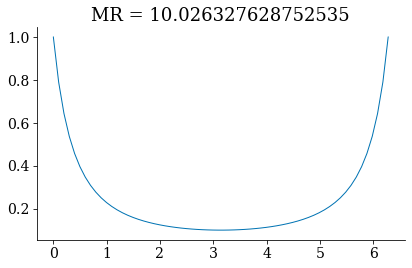

In [88]:
# ---- Grid for axis (rho = 0, theta = 0, zeta from 0 to 2pi) ----
zeta_axis = np.linspace(0, 2*np.pi, 64)
rho_axis = np.zeros_like(zeta_axis)
theta_axis = np.zeros_like(zeta_axis)
grid_axis = Grid(np.stack([rho_axis, theta_axis, zeta_axis], axis=1))

# Compute on axis
data_axis = eq.compute(['|B|', 'p','beta_a','Y'], grid=grid_axis)
B_axis = data_axis['|B|']
p_perp_axis = data_axis["p"]

plt.figure()
plt.plot(zeta_axis,B_axis)
plt.title('MR = {}'.format(np.max(B_axis)/np.min(B_axis)))

In [89]:
B_axis.min(),B_axis.max()

(Array(0.0999367, dtype=float64), Array(1.00199809, dtype=float64))

In [90]:
# %% Get fieldlines on the LCFS
#assert isinstance(eq, Equilibrium)

Nz = 200
Nt = 100
rho_surf = .5

theta = np.linspace(0, 2 * np.pi, Nt)
zeta = np.linspace(0, 2 * np.pi, Nz, endpoint=True)

theta_mesh, zeta_mesh = np.meshgrid(theta, zeta, indexing="ij")
shape = theta_mesh.shape
coords_sfl = np.stack(
    [
        np.ones_like(theta_mesh.reshape(-1))*rho_surf,
        theta_mesh.reshape(-1),
        zeta_mesh.reshape(-1),
    ],
    axis=-1,
)

coords_geo = eq.compute_theta_coords(coords_sfl)
coords_data = eq.compute(["R", "Z", "zeta","p","|B|",'kappa'], grid=Grid(nodes=coords_geo, sort=False))


lines = np.array([coords_data["R"], coords_data["zeta"], coords_data["Z"]])
lines = lines.reshape(3, shape[0], shape[1])
lines = np.moveaxis(lines, [0, 1], [1, 0])

B_on_lines = coords_data["|B|"]
B_on_lines = B_on_lines.reshape(shape[0], shape[1])


p_on_lines = coords_data["p"]
p_on_lines = p_on_lines.reshape(shape[0], shape[1])
k_on_lines = coords_data["kappa"]
k_on_lines = np.linalg.norm(k_on_lines,axis = -1)
k_on_lines = k_on_lines.reshape(shape[0], shape[1])

In [91]:
k_on_lines

array([[0.00048041, 0.00049709, 0.00051347, ..., 0.00051378, 0.00049728,
        0.00048045],
       [0.00048445, 0.0005003 , 0.00051604, ..., 0.00051635, 0.00050048,
        0.00048448],
       [0.00049055, 0.00050544, 0.00052042, ..., 0.00052073, 0.00050563,
        0.00049058],
       ...,
       [0.00047877, 0.00049666, 0.00051387, ..., 0.00051419, 0.00049686,
        0.00047883],
       [0.0004785 , 0.00049587, 0.00051274, ..., 0.00051306, 0.00049607,
        0.00047855],
       [0.00048041, 0.00049709, 0.00051347, ..., 0.00051378, 0.00049728,
        0.00048045]], shape=(100, 200))

In [92]:
from scipy.integrate import simpson as simps

# pressure-weighted curvature integrand
integrand = p_on_lines * k_on_lines  # shape (Nt, Nz)

dR = np.gradient(lines[:, 0, :], axis=1)
dZ = np.gradient(lines[:, 2, :], axis=1)
dphi = np.gradient(lines[:, 1, :], axis=1)
R = lines[:, 0, :]

ds = np.sqrt(dR**2 + dZ**2 + (R * dphi)**2)  # shape (Nt, Nz)

# integrate for each field line using Simpson's rule
stability_integral = np.array([
    simps(integrand[i] * ds[i], dx=1.0)  # dx=1.0 since spacing is uniform in zeta
    for i in range(Nt)
])

In [94]:
data_mesh = eq.compute(['theta','X','Y','Z','|B|','B','p','J','e^theta','e_rho','e^rho','e^zeta','grad(alpha)'],grid=Grid(nodes=coords_geo, sort=False))

### axial pressure profile 
mu0 = 4 * np.pi * 1e-7

# ---- Grid for axis (rho = 0, theta = 0, zeta from 0 to 2pi) ----
zeta_axis = np.linspace(0, 2*np.pi, 100)
rho_axis = np.zeros_like(zeta_axis)
theta_axis = np.zeros_like(zeta_axis)
grid_axis = Grid(np.stack([rho_axis, theta_axis, zeta_axis], axis=1))

# Compute on axis
data_axis = eq.compute(["|B|", "p"], grid=grid_axis)
B_axis = data_axis["|B|"]
p_axis = data_axis["p"]


# ---- Grid for midplane slice (zeta = pi, theta = 0, rho from 0 to 1) ----
rho_mid = np.linspace(0, 1, 100)
theta_mid = np.zeros_like(rho_mid)
zeta_mid = np.ones_like(rho_mid) * np.pi
grid_mid = Grid(np.stack([rho_mid, theta_mid, zeta_mid], axis=1))

# Compute on midplane profile
data_mid = eq.compute(["p",'|B|',"p"], grid=grid_mid)
B_mid = data_mid["|B|"]
p_mid = data_mid["p"]


X2d = np.reshape(data_mesh['X'],(Nz,Nt))
Y2d = np.reshape(data_mesh['Y'],(Nz,Nt))
Z2d = np.reshape(data_mesh['Z'],(Nz,Nt))
B2d = np.reshape(data_mesh['|B|'],(Nz,Nt))
J2d = np.reshape(data_mesh['J'],(Nz,Nt,3))
theta2d = np.reshape(data_mesh['theta'],(Nz,Nt))

etheta = np.reshape(data_mesh['e^theta'],(Nz,Nt,3)) 
ezeta = np.reshape(data_mesh['e^zeta'],(Nz,Nt,3))
erho = np.reshape(data_mesh['e_rho'],(Nz,Nt,3))

e_theta_n = etheta / np.linalg.norm(etheta,axis = -1)[:,:,None]
e_zeta_n = ezeta / np.linalg.norm(ezeta,axis = -1)[:,:,None]
e_rho_n = erho / np.linalg.norm(erho,axis = -1)[:,:,None]

J2d_n = J2d / np.linalg.norm(J2d,axis = -1)[:,:,None]

comp_theta = np.sum(J2d_n*e_theta_n,axis = -1)
comp_zeta = np.sum(J2d_n*e_zeta_n,axis = -1)
comp_rho = np.sum(J2d_n*e_rho_n,axis = -1)

Bv = np.reshape(data_mesh['B'],(Nz,Nt,3))
B2d_n = Bv / np.linalg.norm(Bv,axis = -1)[:,:,None]

JdotB = np.sum(J2d_n*B2d_n,axis = -1)

#gradp = np.reshape(data_mesh['grad(p)'],(Nz,Nt,3))
#gradp_n =  gradp / np.linalg.norm(gradp,axis = -1)[:,:,None]

#Jdotgradp = np.sum(J2d_n*gradp_n,axis = -1)

#Bdotgradp = np.sum(B2d_n*gradp_n,axis = -1)

JdotB2d_n = np.sum(J2d_n*B2d_n,axis = -1)

gradalpha = np.reshape(data_mesh['grad(alpha)'],(Nz,Nt,3))
gradalpha_n = gradalpha / np.linalg.norm(gradalpha,axis = -1)[:,:,None]

Jdotgradalpha_n =  np.sum(J2d_n*gradalpha_n,axis = -1)

beta = 2*(data_mesh['p'])*mu_0 / (data_mesh["|B|"]**2  + 1e-20)  
beta_axis = 2*(data_axis['p'])*mu_0 / (data_axis["|B|"]**2  + 1e-20)
beta_midplane = 2*(data_mid['p'])*mu_0 / (data_mid["|B|"]**2  + 1e-20)


beta2d = np.reshape(beta,(Nz,Nt))

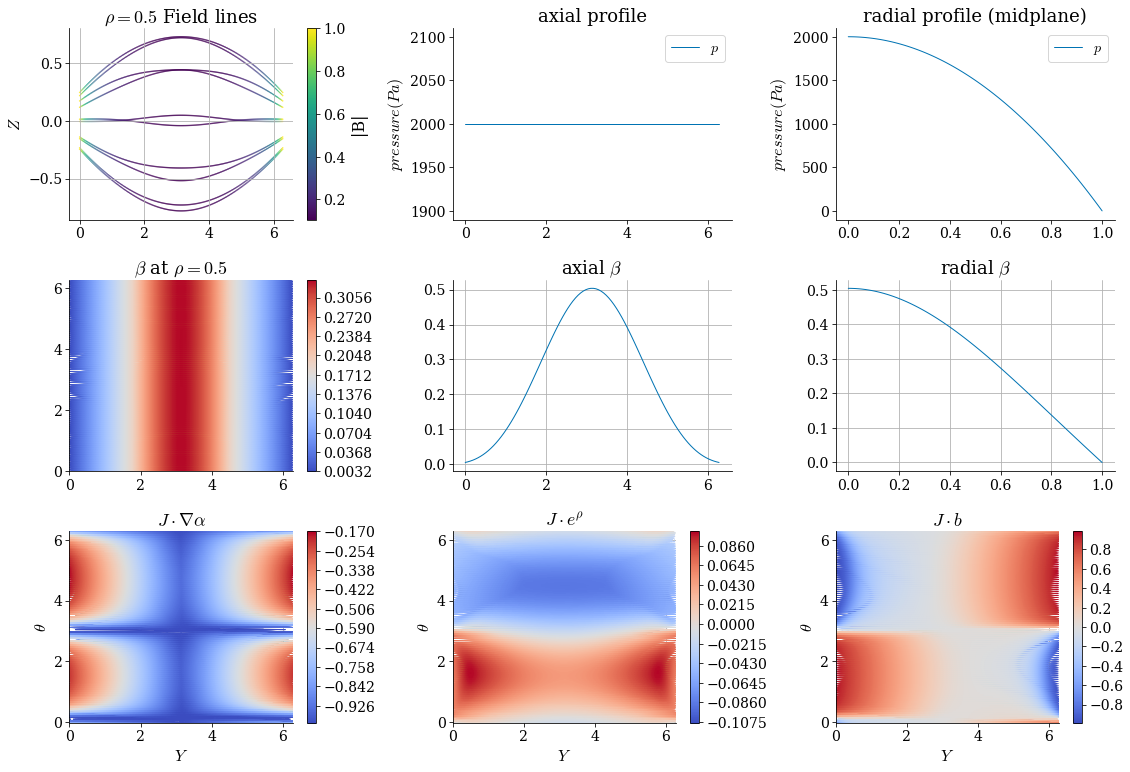

In [95]:
fig, axs = plt.subplots(3,3,figsize=(16, 11))

nlevels = 500
cmap='coolwarm'

# field lines 
i = 0
for line in lines[::10]:
    fieldlines = axs[0,0].scatter(line[1],line[2],c= B_on_lines[i], s = .2)
    i = i + 10
fig.colorbar(fieldlines, ax=axs[0,0],label = r'|B|')

#

axs[0,1].plot(zeta_axis,p_axis, label = r'$p$')
axs[0,1].legend()

axs[0,2].plot(rho_mid,p_mid, label = r'$p$')
axs[0,2].legend()




im = axs[1,0].contour(Y2d,theta2d,beta2d,levels = nlevels,cmap=cmap)
fig.colorbar(im, ax=axs[1,0])


im = axs[1,1].plot(zeta_axis,beta_axis)
im = axs[1,2].plot(rho_mid,beta_midplane)





# J
im = axs[2,1].contour(Y2d,theta2d,comp_rho,levels = nlevels,cmap=cmap)
fig.colorbar(im, ax=axs[2,1])

im = axs[2,0].contour(Y2d,theta2d,Jdotgradalpha_n,levels = nlevels,cmap=cmap)
fig.colorbar(im, ax=axs[2,0])

im = axs[2,2].contour(Y2d,theta2d,JdotB2d_n,levels = nlevels,cmap=cmap)
fig.colorbar(im, ax=axs[2,2])



# titles
axs[0,0].set_title(r'$\rho = {}$ Field lines'.format(rho_surf))
axs[0,1].set_title('axial profile')
axs[0,2].set_title('radial profile (midplane)')

axs[1,0].set_title(r'$\beta$ at $\rho = {}$ '.format(rho_surf))
axs[1,1].set_title(r'axial $\beta$')
axs[1,2].set_title(r'radial $\beta$')

axs[2,2].set_title(r'$J \cdot b$')
axs[2,0].set_title(r'$J \cdot \nabla \alpha$')
axs[2,1].set_title(r'$J \cdot e^\rho$')

axs[0,0].set_ylabel(r'$Z$')
axs[0,1].set_ylabel(r'$pressure(Pa)$')
axs[0,2].set_ylabel(r'$pressure(Pa)$')

axs[2,2].set_ylabel(r'$\theta$')
axs[2,0].set_ylabel(r'$\theta$')
axs[2,1].set_ylabel(r'$\theta$')


axs[2,0].set_xlabel(r'$Y$')
axs[2,1].set_xlabel(r'$Y$')
axs[2,2].set_xlabel(r'$Y$')


axs[0,0].grid()
axs[1,1].grid()
axs[1,2].grid()

axs[2,2].grid()
axs[2,0].grid()
axs[2,1].grid()

fig.tight_layout()

(<Figure size 864.648x576.432 with 1 Axes>,
 <Axes: xlabel='$\\rho$', ylabel='$ \\mathrm{Magnetic ~Well}~(~)$'>)

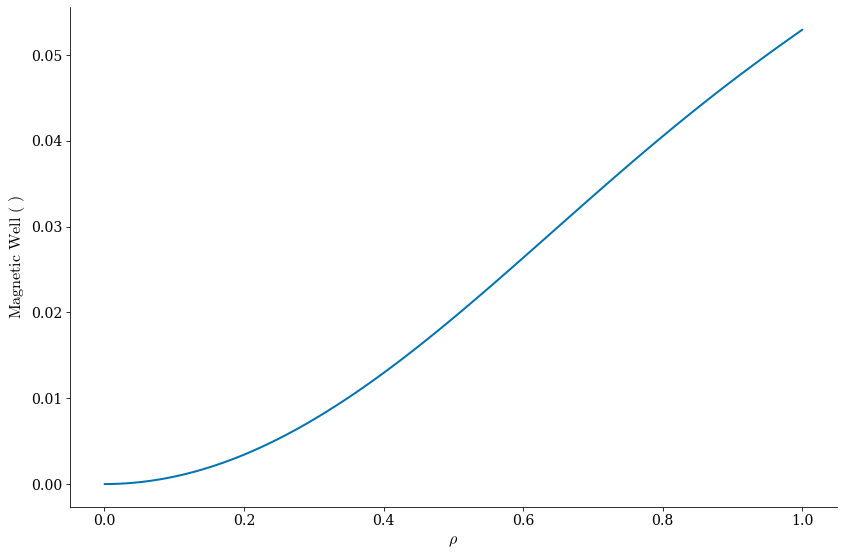

In [96]:
# Create a figure and axis manually
fig, ax = plt.subplots(figsize=(12, 8))

# Plot on the custom axis
desc.plotting.plot_1d(
    eq,
    name="magnetic well",
    ax=ax,         
    lw=2
)